#Setup
Este código es una prueba de un modelo ViT, con un conjunto de datos generados a partir de un tensor con valores aleatorios.

In [ ]:
import torch
from torch import nn
import pandas as pd
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import timeit
from tqdm import tqdm
from tensorflow import keras
import kagglehub
from sklearn.metrics import f1_score

#DEFINICION DE HIPERPARAMETROS

In [ ]:


random_seed = 42
batch_size = 256
num_epochs = 60

learning_rate = 1e-4
n_classes = 10
patch_size = 4
image_size = 28
input_channels = 1
num_heads = 8
batch_size = 256
dropout = 0.2
hidden_dimension = 768
adam_weight_decay = 1e-3
adam_betas = (0.9, 0.999)
activation = 'gelu'
num_encoders = 6
embedding_dimension = patch_size*patch_size*input_channels # 4*4*1 = 16
num_patches = (image_size//patch_size)**2 #(28/4)^2 = 49


random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


##Embedding

In [ ]:
class PatchEmbedding(nn.Module):
  def __init__(self, embedding_dimension, patch_size, num_patches, dropout, input_channels):
    super().__init__()
    """
    Divide la imagen en parches y los convierte en embeddings.

            Inicializa la clase PatchEmbedding.

        Args:
            embedding_dimension (int): Dimensión del embedding para cada parche.
            patch_size (int): Tamaño del parche (lado del cuadrado).
            num_patches (int): Número total de parches en la imagen.
            dropout (float): Probabilidad de dropout.
            input_channels (int): Número de canales de entrada de la imagen.
    """
    self.patcher  = nn.Sequential(
        nn.Conv2d(
            in_channels = input_channels,
            out_channels = embedding_dimension,
            kernel_size = patch_size,
            stride = patch_size
        ),
        nn.Flatten(2)
    )
    self.cls_token = nn.Parameter(torch.randn(size=(1, input_channels, embedding_dimension)), requires_grad=True)
    self.position_embeddings = nn.Parameter(torch.randn(size=(1, num_patches+1, embedding_dimension)), requires_grad=True)
    self.dropout = nn.Dropout(p=dropout)

  def forward(self, x):
    """
    Realiza el forward pass de la clase PatchEmbedding.

    Args:
        x (torch.Tensor): Tensor de entrada con la imagen.

    Returns:
        torch.Tensor: Tensor con los embeddings de los parches y el token de clasificación.
    """
    cls_token = self.cls_token.expand(x.shape[0], -1, -1)
    x = self.patcher(x).permute(0, 2, 1)
    x = torch.cat([cls_token, x], dim=1)
    x = x + self.position_embeddings
    x = self.dropout(x)
    return x



In [ ]:
model = PatchEmbedding(
      embedding_dimension,
      patch_size,
      num_patches,
      dropout,
      input_channels).to(device)

x = torch.randn(512, 1, 28, 28).to(device)
print(model(x).shape)
#torch.size[Batch_size, No. tokens (7*7 +1CLS), embedding dimension]

torch.Size([512, 50, 16])


In [ ]:
class MultiHeadAttention(nn.Module):
    """
    Clase que implementa la atención multi-cabeza.

    Divide la entrada en múltiples cabezas para realizar la atención en paralelo.
    """
    def __init__(self, dim, heads=8, dropout=0.1):

        super(MultiHeadAttention, self).__init__()
        self.heads = heads
        self.scale = dim ** -0.5
        self.to_qkv = nn.Linear(dim, dim * 3, bias=False)
        self.to_out = nn.Sequential(
            nn.Linear(dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        queries, keys, values = map(lambda t: t.reshape(b, n, h, -1).transpose(1, 2), qkv)
        scores = torch.einsum('bhid,bhjd->bhij', queries, keys) * self.scale
        attn = scores.softmax(dim=-1)
        out = torch.einsum('bhij,bhjd->bhid', attn, values).transpose(1, 2).reshape(b, n, -1)
        return self.to_out(out)



##Modelo Visual Transformer

In [ ]:
class ViT(nn.Module):
  """
  Clase que implementa el modelo Vision Transformer (ViT).

  Combina Patch Embedding, capas de Transformer Encoder y una cabeza MLP para la clasificación.
  """

  def __init__(self, num_patches, num_classes, patch_size, embedding_dimension, num_encoders, num_heads, hidden_dimension, dropout, activation, input_channels):
    super().__init__()
    """
        Inicializa la clase ViT.

        Args:
            num_patches (int): Número total de parches en la imagen.
            num_classes (int): Número de clases para la clasificación.
            patch_size (int): Tamaño del parche (lado del cuadrado).
            embedding_dimension (int): Dimensión del embedding para cada parche.
            num_encoders (int): Número de capas de Transformer Encoder.
            num_heads (int): Número de cabezas de atención en cada capa de Transformer Encoder.
            hidden_dimension (int): Dimensión de la capa oculta en la cabeza MLP.
            dropout (float): Probabilidad de dropout.
            activation (str): Función de activación a utilizar en las capas de Transformer Encoder.
            input_channels (int): Número de canales de entrada de la imagen.
    """
    self.embeddings_block = PatchEmbedding(
        embedding_dimension,
        patch_size,
        num_patches,
        dropout,
        input_channels
    )
    encoder_layer = nn.TransformerEncoderLayer(d_model = embedding_dimension, nhead = num_heads, dropout = dropout, activation = activation, batch_first=True, norm_first=True)

    self.encoder_blocks = nn.TransformerEncoder(encoder_layer, num_layers =num_encoders)

        # Nueva capa de atención adicional (añadida después de encoder_blocks)
    self.additional_attention = nn.MultiheadAttention(
            embed_dim=embedding_dimension,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True
        )

    self.mlp_head = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dimension),
        nn.Linear(in_features=embedding_dimension, out_features=num_classes),
    )
  def forward(self, x):
    x = self.embeddings_block(x)
    x = self.encoder_blocks(x)
    x = self.mlp_head(x[:, 0, :])
    return x

In [ ]:
model = ViT(
    num_patches,
    n_classes,
    patch_size,
    embedding_dimension,
    num_encoders,
    num_heads,
    hidden_dimension,
    dropout,
    activation,
    input_channels
)
x = torch.randn(512, 1, 28, 28)
print(model(x).shape)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


torch.Size([512, 10])


#Implementación

In [ ]:
path = kagglehub.dataset_download("zalando-research/fashionmnist")
print("Path to dataset files:", path)

100%|██████████| 68.8M/68.8M [00:02<00:00, 28.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4


In [ ]:
train_df = pd.read_csv(path + '/fashion-mnist_train.csv')
test_df = pd.read_csv(path + '/fashion-mnist_test.csv')

In [ ]:
train_df.head() #Se observa que hay etiquetas

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
test_df.head() #Se observa que no hay etiquetas

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
train_df.shape, test_df.shape

((60000, 785), (10000, 785))

In [ ]:
#Se realiza un split en el conjunto de entrenamiento para obtner un conjunto de validación.
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=random_seed, shuffle = True)


###Preparación de los datos

In [ ]:

class FMNIST_TrainDataset(Dataset):
  def __init__(self, images, labels, indicies):
    self.images = images
    self.labels = labels
    self.indicies = indicies
    self.transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5])
        #Se pueden implementar posteriormente otras técnicas de data augmentation más robustas
    ])
  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    image = self.images[idx].reshape(28,28).astype(np.uint8)
    label = self.labels[idx]
    index = self.indicies[idx]
    image = self.transform(image)
    return {'image':image, 'label':label, 'index':index}

In [ ]:
class FMNIST_ValDataset(Dataset):
  def __init__(self, images, labels, indicies):
    self.images = images
    self.labels = labels
    self.indicies = indicies
    self.transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5])
    ])
  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    image = self.images[idx].reshape(28,28).astype(np.uint8)
    label = self.labels[idx]
    index = self.indicies[idx]
    image = self.transform(image)
    return {'image':image, 'label':label, 'index':index}

In [ ]:
class FMNIST_TestDataset(Dataset):
  def __init__(self, images, indicies):
    self.images = images
    self.indicies = indicies
    self.transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5])
    ])
  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    image = self.images[idx, 1:].reshape(28,28).astype(np.uint8)
    index = self.indicies[idx]
    image = self.transform(image)
    return {'image':image, 'index':index}

###Muestras de los conjuntos de datos

48000
{'image': tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0

<Figure size 640x480 with 0 Axes>

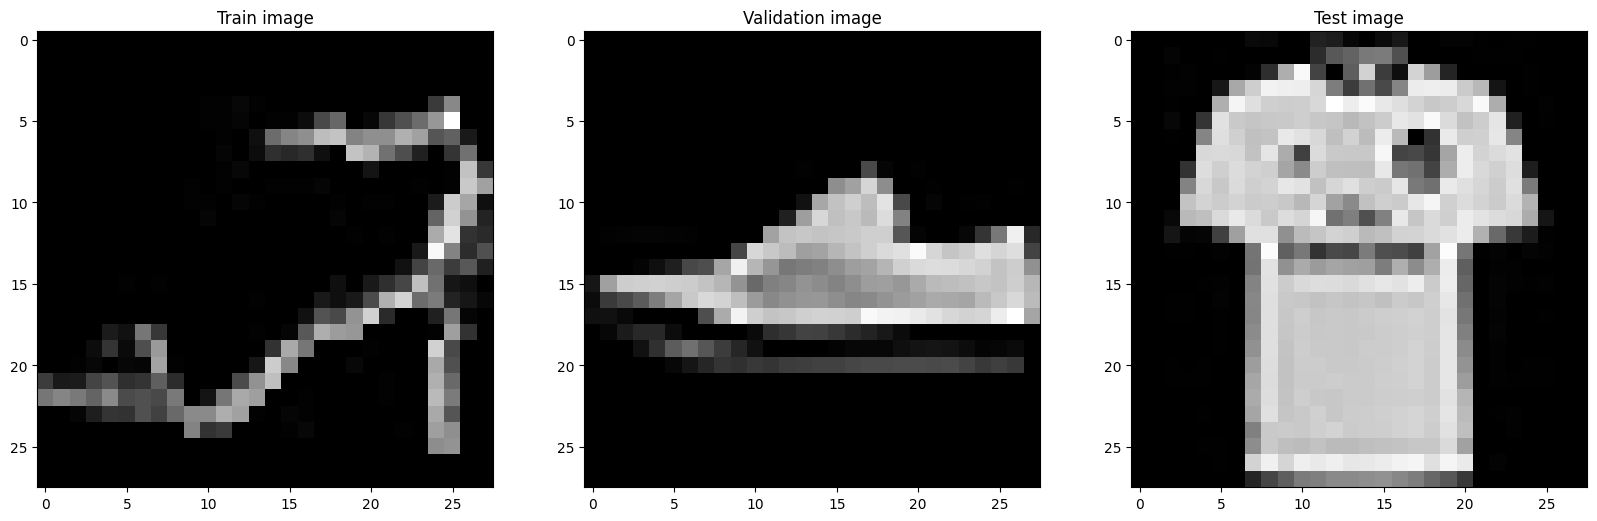

In [ ]:
plt.figure()
f, axarr = plt.subplots(1,3, figsize=(20,20))

train_dataset = FMNIST_TrainDataset(train_df.iloc[:,1:].values.astype(np.uint8), train_df.iloc[:,0].values, train_df.index.values)
print(len(train_dataset))
print(train_dataset[0])
axarr[0].imshow(train_dataset[0]['image'].squeeze(), cmap='gray')
axarr[0].set_title('Train image')
print('-'*30)

val_dataset = FMNIST_ValDataset(val_df.iloc[:,1:].values.astype(np.uint8), val_df.iloc[:,0].values, val_df.index.values)
print(len(val_dataset))
print(val_dataset[0])
axarr[1].imshow(val_dataset[0]['image'].squeeze(), cmap='gray')
axarr[1].set_title('Validation image')
print('-'*30)

test_dataset = FMNIST_TestDataset(test_df.values.astype(np.uint8), test_df.index.values)
print(len(test_dataset))
print(test_dataset[0])
axarr[2].imshow(test_dataset[0]['image'].squeeze(), cmap='gray')
axarr[2].set_title('Test image')
print('-'*30)

plt.show()

In [ ]:
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size = batch_size,
                              shuffle = True)

val_dataloader = DataLoader(dataset=val_dataset,
                              batch_size = batch_size,
                              shuffle = True)

test_dataloader = DataLoader(dataset=test_dataset,
                              batch_size = batch_size,
                              shuffle = True)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), betas =adam_betas, lr=learning_rate, weight_decay = adam_weight_decay)
model.to(device)
start = timeit.default_timer()

#Guardar los valores de los parametros para poder realizar las curvas de aprendizaje

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_f1_scores = []  # Para almacenar el F1 Score de entrenamiento
val_f1_scores = []    # Para almacenar el F1 Score de validación



for epoch in tqdm(range(num_epochs), position=0, leave = True):
  model.train()
  train_labels =[]
  train_preds = []
  train_running_loss = 0
  for idx, img_label in enumerate(tqdm(train_dataloader, position = 0, leave =True )):
    img = img_label['image'].float().to(device)
    label = img_label['label'].type(torch.uint8).to(device)
    y_pred = model(img)
    y_pred_label = torch.argmax(y_pred, dim=1)

    train_labels.extend(label.cpu().detach())
    train_preds.extend(y_pred_label.cpu().detach())

    loss = criterion(y_pred, label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_running_loss += loss.item()
  train_loss = train_running_loss/ (idx+1)
  train_f1 = f1_score(train_labels, train_preds, average='weighted')




  model.eval()
  val_labels = []
  val_preds = []



  val_running_loss = 0
  with torch.no_grad():
    for idx, img_label in enumerate(tqdm(val_dataloader, position = 0, leave =True )):
      img = img_label['image'].float().to(device)
      label = img_label['label'].type(torch.uint8).to(device)
      y_pred = model(img)
      y_pred_label = torch.argmax(y_pred, dim=1)

      val_labels.extend(label.cpu().detach())
      val_preds.extend(y_pred_label.cpu().detach())

      loss += criterion(y_pred, label)
      val_running_loss += loss.item()
  val_loss = val_running_loss/ (idx+1)
  val_f1 = f1_score(val_labels, val_preds, average='weighted')



  train_accuracy = sum(1 for x,y in zip(train_preds, train_labels) if x == y)/len(train_labels)
  val_accuracy=sum(1 for x,y in zip(val_preds, val_labels) if x == y)/len(val_labels)


  # Almacenar los valores de pérdida y precisión en las listas correspondientes
    # Inside your training loop:
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  train_f1_scores.append(train_f1)
  val_f1_scores.append(val_f1)
  train_accuracies.append(train_accuracy)
  val_accuracies.append(val_accuracy)

  print('-'*30)
  print(f'Train Loss Epoch: {epoch+1}: {train_loss:.4f}')
  print(f'Validation Loss Epoch: {epoch+1}: {val_loss:.4f}')
  print('\n')
  print(f'Train Accuracy Epoch: {epoch+1}: {train_accuracy:.4f}')
  print(f'Validation Accuracy Epoch: {epoch+1}: {val_accuracy:.4f}')
  print(f'Train F1 Epoch: {epoch+1}: {train_f1:.4f}')
  print(f'Validation F1 Epoch: {epoch+1}: {val_f1:.4f}')
  print('-'*30)
stop = timeit.default_timer()
print(f'Training Time: {stop - start:.2f}s')


  2%|▏         | 1/60 [00:42<41:32, 42.25s/it]

------------------------------
Train Loss Epoch: 1: 2.1147
Validation Loss Epoch: 1: 47.9211


Train Accuracy Epoch: 1: 0.1934
Validation Accuracy Epoch: 1: 0.2835
Train F1 Epoch: 1: 0.1690
Validation F1 Epoch: 1: 0.1988
------------------------------


  3%|▎         | 2/60 [01:22<39:50, 41.21s/it]

------------------------------
Train Loss Epoch: 2: 1.8373
Validation Loss Epoch: 2: 38.6885


Train Accuracy Epoch: 2: 0.3425
Validation Accuracy Epoch: 2: 0.4592
Train F1 Epoch: 2: 0.3044
Validation F1 Epoch: 2: 0.4078
------------------------------


  5%|▌         | 3/60 [02:03<38:53, 40.95s/it]

------------------------------
Train Loss Epoch: 3: 1.6101
Validation Loss Epoch: 3: 35.0781


Train Accuracy Epoch: 3: 0.4302
Validation Accuracy Epoch: 3: 0.5083
Train F1 Epoch: 3: 0.4030
Validation F1 Epoch: 3: 0.4589
------------------------------


  7%|▋         | 4/60 [02:44<38:15, 41.00s/it]

------------------------------
Train Loss Epoch: 4: 1.4758
Validation Loss Epoch: 4: 32.6308


Train Accuracy Epoch: 4: 0.4761
Validation Accuracy Epoch: 4: 0.5427
Train F1 Epoch: 4: 0.4549
Validation F1 Epoch: 4: 0.5053
------------------------------


  8%|▊         | 5/60 [03:25<37:31, 40.94s/it]

------------------------------
Train Loss Epoch: 5: 1.3880
Validation Loss Epoch: 5: 30.2878


Train Accuracy Epoch: 5: 0.5005
Validation Accuracy Epoch: 5: 0.5707
Train F1 Epoch: 5: 0.4823
Validation F1 Epoch: 5: 0.5330
------------------------------


 10%|█         | 6/60 [04:06<37:01, 41.14s/it]

------------------------------
Train Loss Epoch: 6: 1.3136
Validation Loss Epoch: 6: 28.8521


Train Accuracy Epoch: 6: 0.5217
Validation Accuracy Epoch: 6: 0.5619
Train F1 Epoch: 6: 0.5066
Validation F1 Epoch: 6: 0.5159
------------------------------


 12%|█▏        | 7/60 [04:47<36:16, 41.07s/it]

------------------------------
Train Loss Epoch: 7: 1.2617
Validation Loss Epoch: 7: 27.3804


Train Accuracy Epoch: 7: 0.5353
Validation Accuracy Epoch: 7: 0.5931
Train F1 Epoch: 7: 0.5201
Validation F1 Epoch: 7: 0.5551
------------------------------


 13%|█▎        | 8/60 [05:28<35:29, 40.95s/it]

------------------------------
Train Loss Epoch: 8: 1.2186
Validation Loss Epoch: 8: 26.5359


Train Accuracy Epoch: 8: 0.5474
Validation Accuracy Epoch: 8: 0.6034
Train F1 Epoch: 8: 0.5342
Validation F1 Epoch: 8: 0.5600
------------------------------


 15%|█▌        | 9/60 [06:08<34:30, 40.60s/it]

------------------------------
Train Loss Epoch: 9: 1.1685
Validation Loss Epoch: 9: 25.3559


Train Accuracy Epoch: 9: 0.5660
Validation Accuracy Epoch: 9: 0.6076
Train F1 Epoch: 9: 0.5528
Validation F1 Epoch: 9: 0.5651
------------------------------


 17%|█▋        | 10/60 [06:47<33:27, 40.15s/it]

------------------------------
Train Loss Epoch: 10: 1.1306
Validation Loss Epoch: 10: 23.9548


Train Accuracy Epoch: 10: 0.5785
Validation Accuracy Epoch: 10: 0.6362
Train F1 Epoch: 10: 0.5661
Validation F1 Epoch: 10: 0.5999
------------------------------


 18%|█▊        | 11/60 [07:26<32:37, 39.95s/it]

------------------------------
Train Loss Epoch: 11: 1.0963
Validation Loss Epoch: 11: 23.6890


Train Accuracy Epoch: 11: 0.5930
Validation Accuracy Epoch: 11: 0.6445
Train F1 Epoch: 11: 0.5811
Validation F1 Epoch: 11: 0.6073
------------------------------


 20%|██        | 12/60 [08:06<31:45, 39.70s/it]

------------------------------
Train Loss Epoch: 12: 1.0685
Validation Loss Epoch: 12: 22.1710


Train Accuracy Epoch: 12: 0.6035
Validation Accuracy Epoch: 12: 0.6797
Train F1 Epoch: 12: 0.5935
Validation F1 Epoch: 12: 0.6507
------------------------------


 22%|██▏       | 13/60 [08:46<31:16, 39.93s/it]

------------------------------
Train Loss Epoch: 13: 1.0483
Validation Loss Epoch: 13: 21.8913


Train Accuracy Epoch: 13: 0.6081
Validation Accuracy Epoch: 13: 0.6766
Train F1 Epoch: 13: 0.5971
Validation F1 Epoch: 13: 0.6444
------------------------------


 23%|██▎       | 14/60 [09:26<30:34, 39.89s/it]

------------------------------
Train Loss Epoch: 14: 1.0232
Validation Loss Epoch: 14: 21.5017


Train Accuracy Epoch: 14: 0.6206
Validation Accuracy Epoch: 14: 0.6880
Train F1 Epoch: 14: 0.6101
Validation F1 Epoch: 14: 0.6669
------------------------------


 25%|██▌       | 15/60 [10:06<30:01, 40.03s/it]

------------------------------
Train Loss Epoch: 15: 0.9995
Validation Loss Epoch: 15: 21.1034


Train Accuracy Epoch: 15: 0.6289
Validation Accuracy Epoch: 15: 0.6820
Train F1 Epoch: 15: 0.6195
Validation F1 Epoch: 15: 0.6564
------------------------------


 27%|██▋       | 16/60 [10:46<29:25, 40.12s/it]

------------------------------
Train Loss Epoch: 16: 0.9821
Validation Loss Epoch: 16: 21.4399


Train Accuracy Epoch: 16: 0.6342
Validation Accuracy Epoch: 16: 0.6904
Train F1 Epoch: 16: 0.6240
Validation F1 Epoch: 16: 0.6597
------------------------------


 28%|██▊       | 17/60 [11:26<28:41, 40.03s/it]

------------------------------
Train Loss Epoch: 17: 0.9717
Validation Loss Epoch: 17: 20.2991


Train Accuracy Epoch: 17: 0.6378
Validation Accuracy Epoch: 17: 0.6963
Train F1 Epoch: 17: 0.6273
Validation F1 Epoch: 17: 0.6730
------------------------------


 30%|███       | 18/60 [12:06<27:59, 39.98s/it]

------------------------------
Train Loss Epoch: 18: 0.9563
Validation Loss Epoch: 18: 20.2620


Train Accuracy Epoch: 18: 0.6425
Validation Accuracy Epoch: 18: 0.6913
Train F1 Epoch: 18: 0.6326
Validation F1 Epoch: 18: 0.6598
------------------------------


 32%|███▏      | 19/60 [12:45<27:07, 39.70s/it]

------------------------------
Train Loss Epoch: 19: 0.9441
Validation Loss Epoch: 19: 19.9871


Train Accuracy Epoch: 19: 0.6449
Validation Accuracy Epoch: 19: 0.7006
Train F1 Epoch: 19: 0.6339
Validation F1 Epoch: 19: 0.6753
------------------------------


 33%|███▎      | 20/60 [13:25<26:25, 39.63s/it]

------------------------------
Train Loss Epoch: 20: 0.9391
Validation Loss Epoch: 20: 19.9027


Train Accuracy Epoch: 20: 0.6466
Validation Accuracy Epoch: 20: 0.6927
Train F1 Epoch: 20: 0.6366
Validation F1 Epoch: 20: 0.6639
------------------------------


 35%|███▌      | 21/60 [14:10<26:53, 41.38s/it]

------------------------------
Train Loss Epoch: 21: 0.9250
Validation Loss Epoch: 21: 19.6146


Train Accuracy Epoch: 21: 0.6542
Validation Accuracy Epoch: 21: 0.7013
Train F1 Epoch: 21: 0.6429
Validation F1 Epoch: 21: 0.6749
------------------------------


 37%|███▋      | 22/60 [14:51<26:01, 41.09s/it]

------------------------------
Train Loss Epoch: 22: 0.9125
Validation Loss Epoch: 22: 19.7148


Train Accuracy Epoch: 22: 0.6557
Validation Accuracy Epoch: 22: 0.7047
Train F1 Epoch: 22: 0.6456
Validation F1 Epoch: 22: 0.6744
------------------------------


 38%|███▊      | 23/60 [15:31<25:17, 41.02s/it]

------------------------------
Train Loss Epoch: 23: 0.9017
Validation Loss Epoch: 23: 19.6458


Train Accuracy Epoch: 23: 0.6617
Validation Accuracy Epoch: 23: 0.7039
Train F1 Epoch: 23: 0.6503
Validation F1 Epoch: 23: 0.6693
------------------------------


 40%|████      | 24/60 [16:11<24:25, 40.70s/it]

------------------------------
Train Loss Epoch: 24: 0.8983
Validation Loss Epoch: 24: 19.3444


Train Accuracy Epoch: 24: 0.6611
Validation Accuracy Epoch: 24: 0.7003
Train F1 Epoch: 24: 0.6501
Validation F1 Epoch: 24: 0.6745
------------------------------


 42%|████▏     | 25/60 [16:51<23:35, 40.43s/it]

------------------------------
Train Loss Epoch: 25: 0.8936
Validation Loss Epoch: 25: 18.7811


Train Accuracy Epoch: 25: 0.6634
Validation Accuracy Epoch: 25: 0.7151
Train F1 Epoch: 25: 0.6522
Validation F1 Epoch: 25: 0.6845
------------------------------


 43%|████▎     | 26/60 [17:31<22:46, 40.18s/it]

------------------------------
Train Loss Epoch: 26: 0.8863
Validation Loss Epoch: 26: 18.8174


Train Accuracy Epoch: 26: 0.6679
Validation Accuracy Epoch: 26: 0.7102
Train F1 Epoch: 26: 0.6560
Validation F1 Epoch: 26: 0.6811
------------------------------


 45%|████▌     | 27/60 [18:14<22:37, 41.14s/it]

------------------------------
Train Loss Epoch: 27: 0.8755
Validation Loss Epoch: 27: 19.0774


Train Accuracy Epoch: 27: 0.6681
Validation Accuracy Epoch: 27: 0.7102
Train F1 Epoch: 27: 0.6573
Validation F1 Epoch: 27: 0.6804
------------------------------


 47%|████▋     | 28/60 [19:08<24:00, 45.01s/it]

------------------------------
Train Loss Epoch: 28: 0.8697
Validation Loss Epoch: 28: 18.4014


Train Accuracy Epoch: 28: 0.6733
Validation Accuracy Epoch: 28: 0.7147
Train F1 Epoch: 28: 0.6618
Validation F1 Epoch: 28: 0.6884
------------------------------


 48%|████▊     | 29/60 [19:55<23:33, 45.60s/it]

------------------------------
Train Loss Epoch: 29: 0.8658
Validation Loss Epoch: 29: 18.5373


Train Accuracy Epoch: 29: 0.6728
Validation Accuracy Epoch: 29: 0.7179
Train F1 Epoch: 29: 0.6611
Validation F1 Epoch: 29: 0.6857
------------------------------


 50%|█████     | 30/60 [20:35<21:54, 43.80s/it]

------------------------------
Train Loss Epoch: 30: 0.8586
Validation Loss Epoch: 30: 18.1477


Train Accuracy Epoch: 30: 0.6762
Validation Accuracy Epoch: 30: 0.7223
Train F1 Epoch: 30: 0.6632
Validation F1 Epoch: 30: 0.6954
------------------------------


 52%|█████▏    | 31/60 [21:15<20:38, 42.69s/it]

------------------------------
Train Loss Epoch: 31: 0.8525
Validation Loss Epoch: 31: 18.8469


Train Accuracy Epoch: 31: 0.6785
Validation Accuracy Epoch: 31: 0.7047
Train F1 Epoch: 31: 0.6667
Validation F1 Epoch: 31: 0.6778
------------------------------


 53%|█████▎    | 32/60 [21:56<19:38, 42.09s/it]

------------------------------
Train Loss Epoch: 32: 0.8471
Validation Loss Epoch: 32: 17.8387


Train Accuracy Epoch: 32: 0.6799
Validation Accuracy Epoch: 32: 0.7210
Train F1 Epoch: 32: 0.6678
Validation F1 Epoch: 32: 0.6923
------------------------------


 55%|█████▌    | 33/60 [22:36<18:42, 41.58s/it]

------------------------------
Train Loss Epoch: 33: 0.8448
Validation Loss Epoch: 33: 17.8499


Train Accuracy Epoch: 33: 0.6782
Validation Accuracy Epoch: 33: 0.7213
Train F1 Epoch: 33: 0.6661
Validation F1 Epoch: 33: 0.6953
------------------------------


 57%|█████▋    | 34/60 [23:21<18:27, 42.61s/it]

------------------------------
Train Loss Epoch: 34: 0.8382
Validation Loss Epoch: 34: 18.2353


Train Accuracy Epoch: 34: 0.6825
Validation Accuracy Epoch: 34: 0.7151
Train F1 Epoch: 34: 0.6711
Validation F1 Epoch: 34: 0.6866
------------------------------


 58%|█████▊    | 35/60 [24:20<19:45, 47.44s/it]

------------------------------
Train Loss Epoch: 35: 0.8378
Validation Loss Epoch: 35: 17.8969


Train Accuracy Epoch: 35: 0.6826
Validation Accuracy Epoch: 35: 0.7247
Train F1 Epoch: 35: 0.6700
Validation F1 Epoch: 35: 0.6969
------------------------------


 60%|██████    | 36/60 [25:06<18:47, 46.96s/it]

------------------------------
Train Loss Epoch: 36: 0.8297
Validation Loss Epoch: 36: 17.7425


Train Accuracy Epoch: 36: 0.6864
Validation Accuracy Epoch: 36: 0.7322
Train F1 Epoch: 36: 0.6751
Validation F1 Epoch: 36: 0.7066
------------------------------


 62%|██████▏   | 37/60 [25:46<17:15, 45.00s/it]

------------------------------
Train Loss Epoch: 37: 0.8272
Validation Loss Epoch: 37: 18.9816


Train Accuracy Epoch: 37: 0.6881
Validation Accuracy Epoch: 37: 0.7115
Train F1 Epoch: 37: 0.6762
Validation F1 Epoch: 37: 0.6788
------------------------------


 63%|██████▎   | 38/60 [26:26<16:00, 43.66s/it]

------------------------------
Train Loss Epoch: 38: 0.8163
Validation Loss Epoch: 38: 17.4533


Train Accuracy Epoch: 38: 0.6910
Validation Accuracy Epoch: 38: 0.7274
Train F1 Epoch: 38: 0.6788
Validation F1 Epoch: 38: 0.7018
------------------------------


 65%|██████▌   | 39/60 [27:07<14:58, 42.78s/it]

------------------------------
Train Loss Epoch: 39: 0.8184
Validation Loss Epoch: 39: 17.8157


Train Accuracy Epoch: 39: 0.6890
Validation Accuracy Epoch: 39: 0.7253
Train F1 Epoch: 39: 0.6765
Validation F1 Epoch: 39: 0.6995
------------------------------


 67%|██████▋   | 40/60 [27:48<14:01, 42.09s/it]

------------------------------
Train Loss Epoch: 40: 0.8130
Validation Loss Epoch: 40: 17.6890


Train Accuracy Epoch: 40: 0.6936
Validation Accuracy Epoch: 40: 0.7316
Train F1 Epoch: 40: 0.6818
Validation F1 Epoch: 40: 0.7064
------------------------------


 68%|██████▊   | 41/60 [28:31<13:28, 42.53s/it]

------------------------------
Train Loss Epoch: 41: 0.8100
Validation Loss Epoch: 41: 18.2452


Train Accuracy Epoch: 41: 0.6941
Validation Accuracy Epoch: 41: 0.7221
Train F1 Epoch: 41: 0.6824
Validation F1 Epoch: 41: 0.6908
------------------------------


 70%|███████   | 42/60 [29:11<12:31, 41.74s/it]

------------------------------
Train Loss Epoch: 42: 0.8022
Validation Loss Epoch: 42: 17.5339


Train Accuracy Epoch: 42: 0.6951
Validation Accuracy Epoch: 42: 0.7303
Train F1 Epoch: 42: 0.6823
Validation F1 Epoch: 42: 0.7041
------------------------------


 72%|███████▏  | 43/60 [29:51<11:38, 41.07s/it]

------------------------------
Train Loss Epoch: 43: 0.8019
Validation Loss Epoch: 43: 17.0666


Train Accuracy Epoch: 43: 0.6976
Validation Accuracy Epoch: 43: 0.7392
Train F1 Epoch: 43: 0.6860
Validation F1 Epoch: 43: 0.7121
------------------------------


 73%|███████▎  | 44/60 [30:30<10:49, 40.62s/it]

------------------------------
Train Loss Epoch: 44: 0.7993
Validation Loss Epoch: 44: 17.7324


Train Accuracy Epoch: 44: 0.6985
Validation Accuracy Epoch: 44: 0.7278
Train F1 Epoch: 44: 0.6862
Validation F1 Epoch: 44: 0.7001
------------------------------


 75%|███████▌  | 45/60 [31:10<10:05, 40.38s/it]

------------------------------
Train Loss Epoch: 45: 0.7952
Validation Loss Epoch: 45: 17.8052


Train Accuracy Epoch: 45: 0.6990
Validation Accuracy Epoch: 45: 0.7244
Train F1 Epoch: 45: 0.6869
Validation F1 Epoch: 45: 0.6947
------------------------------


 77%|███████▋  | 46/60 [31:49<09:20, 40.04s/it]

------------------------------
Train Loss Epoch: 46: 0.7933
Validation Loss Epoch: 46: 17.1613


Train Accuracy Epoch: 46: 0.7015
Validation Accuracy Epoch: 46: 0.7360
Train F1 Epoch: 46: 0.6891
Validation F1 Epoch: 46: 0.7068
------------------------------


 78%|███████▊  | 47/60 [32:29<08:39, 39.93s/it]

------------------------------
Train Loss Epoch: 47: 0.7866
Validation Loss Epoch: 47: 18.2600


Train Accuracy Epoch: 47: 0.7025
Validation Accuracy Epoch: 47: 0.7163
Train F1 Epoch: 47: 0.6904
Validation F1 Epoch: 47: 0.6919
------------------------------


 80%|████████  | 48/60 [33:09<08:00, 40.00s/it]

------------------------------
Train Loss Epoch: 48: 0.7836
Validation Loss Epoch: 48: 17.4973


Train Accuracy Epoch: 48: 0.7034
Validation Accuracy Epoch: 48: 0.7328
Train F1 Epoch: 48: 0.6916
Validation F1 Epoch: 48: 0.7073
------------------------------


 82%|████████▏ | 49/60 [33:49<07:20, 40.05s/it]

------------------------------
Train Loss Epoch: 49: 0.7846
Validation Loss Epoch: 49: 17.3996


Train Accuracy Epoch: 49: 0.7049
Validation Accuracy Epoch: 49: 0.7323
Train F1 Epoch: 49: 0.6928
Validation F1 Epoch: 49: 0.7076
------------------------------


 83%|████████▎ | 50/60 [34:29<06:40, 40.01s/it]

------------------------------
Train Loss Epoch: 50: 0.7818
Validation Loss Epoch: 50: 16.9825


Train Accuracy Epoch: 50: 0.7063
Validation Accuracy Epoch: 50: 0.7388
Train F1 Epoch: 50: 0.6945
Validation F1 Epoch: 50: 0.7104
------------------------------


 85%|████████▌ | 51/60 [35:15<06:15, 41.75s/it]

------------------------------
Train Loss Epoch: 51: 0.7751
Validation Loss Epoch: 51: 17.3158


Train Accuracy Epoch: 51: 0.7088
Validation Accuracy Epoch: 51: 0.7356
Train F1 Epoch: 51: 0.6962
Validation F1 Epoch: 51: 0.7071
------------------------------


 87%|████████▋ | 52/60 [35:59<05:39, 42.43s/it]

------------------------------
Train Loss Epoch: 52: 0.7779
Validation Loss Epoch: 52: 16.9609


Train Accuracy Epoch: 52: 0.7071
Validation Accuracy Epoch: 52: 0.7409
Train F1 Epoch: 52: 0.6949
Validation F1 Epoch: 52: 0.7165
------------------------------


 88%|████████▊ | 53/60 [36:38<04:50, 41.53s/it]

------------------------------
Train Loss Epoch: 53: 0.7656
Validation Loss Epoch: 53: 17.0735


Train Accuracy Epoch: 53: 0.7096
Validation Accuracy Epoch: 53: 0.7391
Train F1 Epoch: 53: 0.6978
Validation F1 Epoch: 53: 0.7116
------------------------------


 90%|█████████ | 54/60 [37:18<04:06, 41.04s/it]

------------------------------
Train Loss Epoch: 54: 0.7636
Validation Loss Epoch: 54: 17.2674


Train Accuracy Epoch: 54: 0.7122
Validation Accuracy Epoch: 54: 0.7378
Train F1 Epoch: 54: 0.7001
Validation F1 Epoch: 54: 0.7118
------------------------------


 92%|█████████▏| 55/60 [37:58<03:22, 40.55s/it]

------------------------------
Train Loss Epoch: 55: 0.7631
Validation Loss Epoch: 55: 16.8752


Train Accuracy Epoch: 55: 0.7116
Validation Accuracy Epoch: 55: 0.7384
Train F1 Epoch: 55: 0.6994
Validation F1 Epoch: 55: 0.7093
------------------------------


 93%|█████████▎| 56/60 [38:38<02:41, 40.32s/it]

------------------------------
Train Loss Epoch: 56: 0.7627
Validation Loss Epoch: 56: 16.5243


Train Accuracy Epoch: 56: 0.7134
Validation Accuracy Epoch: 56: 0.7481
Train F1 Epoch: 56: 0.7026
Validation F1 Epoch: 56: 0.7187
------------------------------


 95%|█████████▌| 57/60 [39:17<02:00, 40.13s/it]

------------------------------
Train Loss Epoch: 57: 0.7607
Validation Loss Epoch: 57: 16.8328


Train Accuracy Epoch: 57: 0.7133
Validation Accuracy Epoch: 57: 0.7449
Train F1 Epoch: 57: 0.7026
Validation F1 Epoch: 57: 0.7168
------------------------------


 97%|█████████▋| 58/60 [39:57<01:19, 39.87s/it]

------------------------------
Train Loss Epoch: 58: 0.7574
Validation Loss Epoch: 58: 16.3349


Train Accuracy Epoch: 58: 0.7152
Validation Accuracy Epoch: 58: 0.7535
Train F1 Epoch: 58: 0.7039
Validation F1 Epoch: 58: 0.7316
------------------------------


 98%|█████████▊| 59/60 [40:36<00:39, 39.74s/it]

------------------------------
Train Loss Epoch: 59: 0.7585
Validation Loss Epoch: 59: 16.0674


Train Accuracy Epoch: 59: 0.7155
Validation Accuracy Epoch: 59: 0.7488
Train F1 Epoch: 59: 0.7050
Validation F1 Epoch: 59: 0.7226
------------------------------


100%|██████████| 60/60 [41:15<00:00, 41.26s/it]

------------------------------
Train Loss Epoch: 60: 0.7532
Validation Loss Epoch: 60: 16.4893


Train Accuracy Epoch: 60: 0.7176
Validation Accuracy Epoch: 60: 0.7478
Train F1 Epoch: 60: 0.7066
Validation F1 Epoch: 60: 0.7234
------------------------------
Training Time: 2475.85s


In [ ]:
torch.cuda.empty_cache()

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

labels = []
ids = []
imgs = []
test_loss = 0  # Inicializa la pérdida total

model.eval()
with torch.no_grad():
  for idx, sample in enumerate(tqdm(test_dataloader, position = 0, leave =True )):
    img = sample['image'].to(device)
    ids.extend([int(i)+1 for i in sample['index']])
    outputs = model(img)
    imgs.extend(img.detach().cpu())
    _, predicted = torch.max(outputs, 1)  # Obtiene las predicciones
    labels.extend([int(i) for i in torch.argmax(outputs, dim=1)])

    # Calcula la pérdida para este batch y acumula
    loss = criterion(outputs, predicted.to(device))
    # Asegúrate de que predicted esté en el dispositivo correcto
    test_loss += loss.item()


# Calcula las métricas después del bucle
test_accuracy = accuracy_score(test_df.iloc[:,0].values, labels)
test_f1 = f1_score(test_df.iloc[:,0].values, labels, average='weighted')
test_loss /= len(test_dataloader)  # Calcula la pérdida promedio

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Loss: {test_loss:.4f}")



100%|██████████| 40/40 [00:02<00:00, 17.29it/s]

Test Accuracy: 0.1051
Test F1 Score: 0.1002
Test Loss: 0.3163


In [ ]:
label_names = {
        0: "T-shirt/top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle boot"
    }


<Figure size 640x480 with 0 Axes>

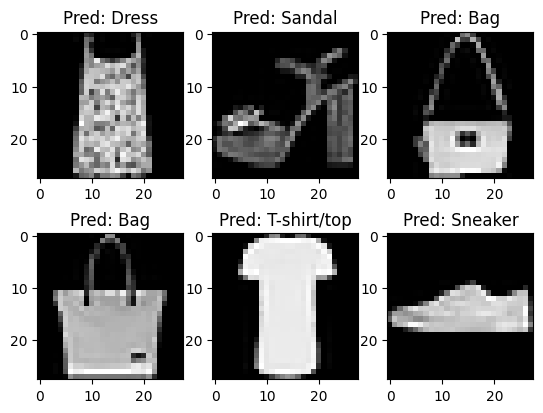

In [ ]:
plt.figure()
f,axarr =  plt.subplots(2,3)
counter = 0
for i in range(2):
  for j in range(3):
    axarr[i,j].imshow(imgs[counter].squeeze(), cmap='gray')
    axarr[i,j].set_title(f'Pred: {label_names[labels[counter]]}') #Implementar un diccionario que permita mostrar el nombre de cada predicción.
    counter += 1

plt.show()

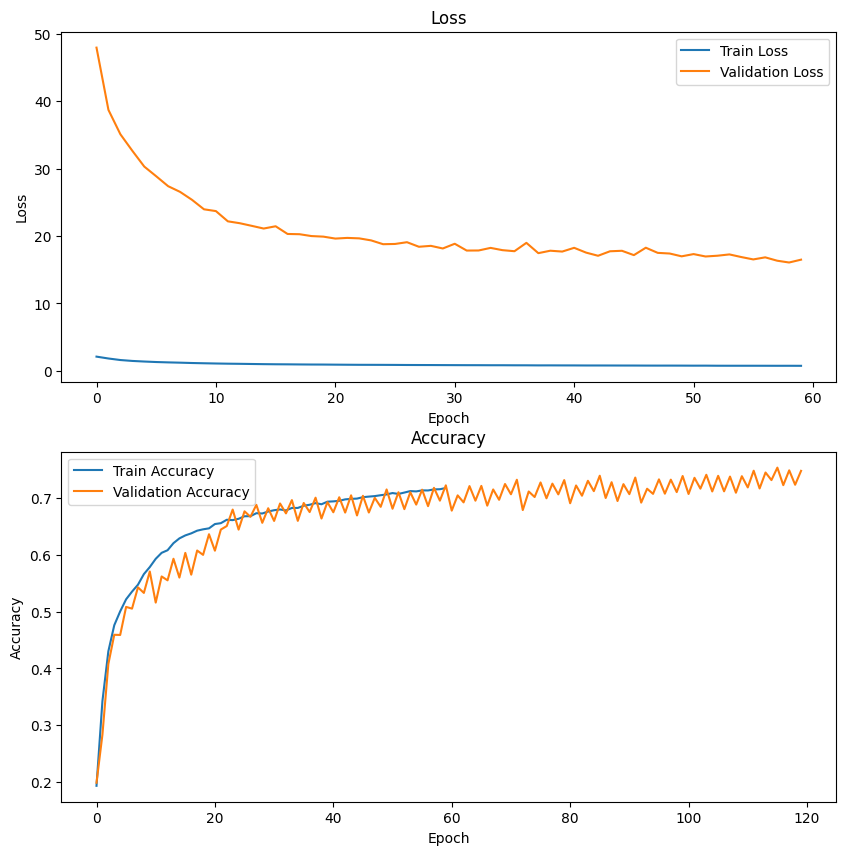

In [ ]:
import matplotlib.pyplot as plt

# Define tus listas de valores para las curvas de aprendizaje
# train_losses, val_losses, train_accuracies, val_accuracies

# Crea una figura y un conjunto de ejes
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
# Grafica la pérdida de entrenamiento y validación
axs[0].plot(train_losses, label='Train Loss')
axs[0].plot(val_losses, label='Validation Loss')
axs[0].set_title('Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Grafica la precisión de entrenamiento y validación
axs[1].plot(train_accuracies, label='Train Accuracy')
axs[1].plot(val_accuracies, label='Validation Accuracy')
axs[1].set_title('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# Grafica el valor f1 de entrenamiento y validación
axs[2].plot(train_f1_scores, label='Train F1 Score')
axs[2].plot(val_f1_scores, label='Validation F1_Score')
axs[2].set_title('F1 Score')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('F1 Score')
axs[2].legend()

# Muestra la gráfica
plt.show()